### Overview
In this notebook, we simulate the Filecoin economy across a range of onboarding, renewal rate, and FIL+ rates. We then 

### Approach

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from typing import Sequence
import os

from datetime import date, timedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import numpy as np

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import random

import optax
from jaxopt import OptaxSolver
from jaxopt import objective

import flax.linen as nn

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C

import cel_utils.disk_utils as du

from tqdm.auto import tqdm

In [5]:
auth_token_fp = '/Users/vkalghatgi/Dropbox/Mac/Desktop/vik_spacescope_auth.json'
offline_data = 'offline'
#os.makedirs(offline_data, exist_ok=True)
#output_dir = '/Users/kiran/Documents/lock_target'
#os.makedirs(output_dir, exist_ok=True)

In [6]:
start_date = date(2023, 6, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*10
end_date = current_date + timedelta(days=forecast_length)

@du.cache_data(directory=offline_data)
def get_offline_data():
    return data.get_simulation_data(auth_token_fp, start_date, current_date, end_date)
jax_offline_data = get_offline_data()

/Users/vkalghatgi/Dropbox/Protocol_Labs/filecoin-mecha-twin/mechafil/data.py:170: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  date_df = df[df["date"] >= pd.to_datetime(date, utc="UTC")]
/Users/vkalghatgi/Dropbox/Protocol_Labs/filecoin-mecha-twin/mechafil/data.py:153: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  init_baseline_bytes = bp_df[bp_df["date"] >= pd.to_datetime(date, utc="UTC")].iloc[


In [7]:
rbp_delta = 1
rr_delta = 0.02
rbp_vec = np.arange(5, 200+rbp_delta, rbp_delta)
rr_vec = np.arange(0.5, 0.9+rr_delta, rr_delta)
fpr_vec = np.asarray([0.5, 0.9])
sector_duration_vec = [360, 720]

nsim = len(rbp_vec) * len(rr_vec) * len(fpr_vec) * len(sector_duration_vec)
print(nsim)

16464


In [9]:
lock_target=0.3

@du.cache_data(directory=offline_data)
def run_sim():
    results_dict = {}
    pbar = tqdm(total=nsim)
    for rbp_val in rbp_vec:
        for rr_val in rr_vec:
            for fpr_val in fpr_vec:
                for sector_duration in sector_duration_vec:
                    rbp = jnp.ones(forecast_length) * rbp_val
                    rr = jnp.ones(forecast_length) * rr_val
                    fpr = jnp.ones(forecast_length) * fpr_val

                    simulation_results = sim.run_sim(
                        rbp,
                        rr,
                        fpr,
                        lock_target,

                        start_date,
                        current_date,
                        forecast_length,
                        sector_duration,
                        jax_offline_data, 
                        gamma=1,
                    )

                    key = (rbp_val, rr_val, fpr_val, sector_duration)
                    results_dict[key] = simulation_results
                    pbar.update(1)
    return results_dict

results = run_sim()

  0%|          | 0/16464 [00:00<?, ?it/s]

In [10]:
def get_heat_matrix(fpr, duration):
    output_matrix = []
    for rbp in rbp_vec:
        rr_scan = []
        for rr in rr_vec:
            key = (rbp, rr, fpr, duration)
            res = results[key]
            locked = np.median(res['network_locked'][-360:])
            cs = np.median(res['circ_supply'][-360:])
            l_over_cs = locked/cs
            
            rr_scan.append(np.nanmedian(l_over_cs))
        output_matrix.append(rr_scan)
            
    return np.asarray(output_matrix)

def plot_heat_matrix(ax, fpr, sector_duration, cbar_ax=None):
    mat = get_heat_matrix(fpr, sector_duration)
    sns.heatmap(mat, ax=ax, cbar_ax=cbar_ax, center=lock_target)
    ax.set_title('FPR=%0.02f Duration=%d' % (fpr, sector_duration))
    

<IPython.core.display.Javascript object>


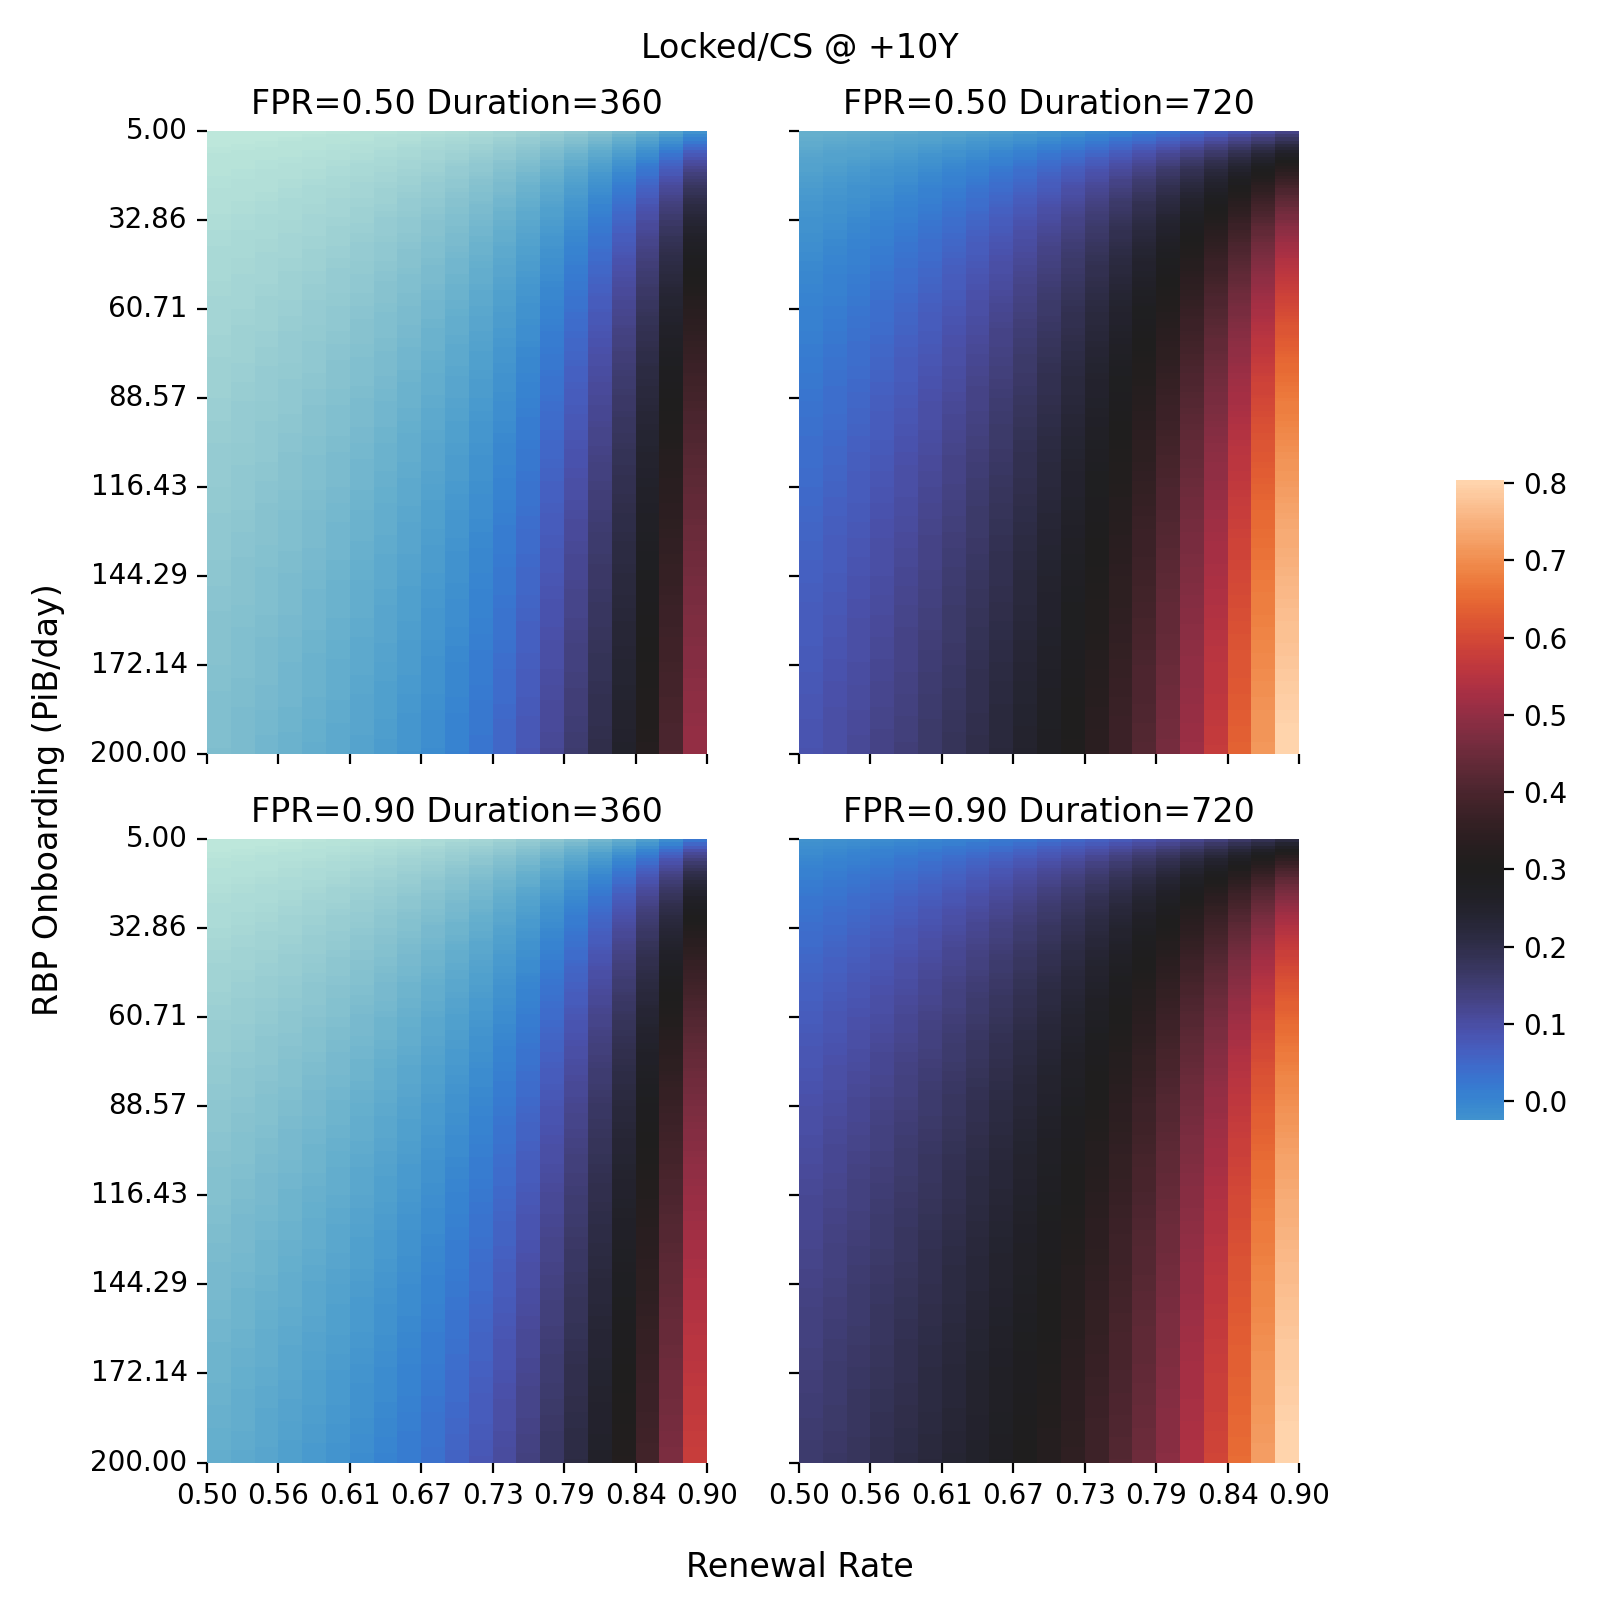

/var/folders/02/9pcr9vq51lg3n4t_l42sw_n80000gn/T/ipykernel_56673/1689321048.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


FileNotFoundError: [Errno 2] No such file or directory: '/Users/kiran/Documents/lock_target/heatmap.png'

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8,8))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

num_ticks = 8
xt = np.linspace(0,len(rr_vec),num_ticks).astype(int)
xtl = ['%0.02f' % x for x in np.linspace(min(rr_vec), max(rr_vec), num_ticks)]
yt = np.linspace(0,len(rbp_vec),num_ticks).astype(int)
ytl = ['%0.02f' % x for x in np.linspace(min(rbp_vec), max(rbp_vec), num_ticks)]

plot_heat_matrix(ax[0,0], 0.5, 360, cbar_ax)
ax[0,0].set_xticks(xt); ax[0,0].set_xticklabels(xtl)
ax[0,0].set_yticks(yt); ax[0,0].set_yticklabels(ytl)
plot_heat_matrix(ax[0,1], 0.5, 720, cbar_ax)
ax[0,1].set_xticks(xt); ax[0,1].set_xticklabels(xtl)
ax[0,1].set_yticks(yt); ax[0,1].set_yticklabels(ytl)
plot_heat_matrix(ax[1,0], 0.9, 360, cbar_ax)
ax[1,0].set_xticks(xt); ax[1,0].set_xticklabels(xtl)
ax[1,0].set_yticks(yt); ax[1,0].set_yticklabels(ytl)
plot_heat_matrix(ax[1,1], 0.9, 720, cbar_ax)
ax[1,1].set_xticks(xt); ax[1,1].set_xticklabels(xtl)
ax[1,1].set_yticks(yt); ax[1,1].set_yticklabels(ytl)

fig.supxlabel('Renewal Rate')
fig.supylabel('RBP Onboarding (PiB/day)')
fig.suptitle('Locked/CS @ +10Y')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig(os.path.join(output_dir, 'heatmap.png'))

In [ ]:
def get_l_cs_trajectory(rbp, rr, fpr, duration):
    # get closest values
    rbp_closest = rbp_vec[np.argmin(np.abs(rbp_vec-rbp))]
    rr_closest = rr_vec[np.argmin(np.abs(rr_vec-rr))]
    key = (rbp_closest, rr_closest, fpr, duration)
    res = results[key]
    locked = res['network_locked']
    cs = res['circ_supply']
    l_over_cs = locked/cs

    return l_over_cs

def plot_l_over_cs(ax, fpr, sector_duration, color_idx=0):
    colors = ['Blues', 'Oranges', 'Greens', 'Purples', 'Greys', 'Reds']
    num_lines = len(rbp_vec) * len(rr_vec)
    cmap_access_vec = np.linspace(0.05, 0.95, len(rbp_vec))
    
    ne = 10
    idx = np.round(np.linspace(0, len(rbp_vec) - 1, ne)).astype(int)
    rbp_plot_vec = rbp_vec[idx]

    ne = 6
    idx = np.round(np.linspace(0, len(rr_vec) - 1, ne)).astype(int)
    rr_plot_vec = rr_vec[idx]
    for ii, rbp in enumerate(rbp_vec):
        for jj, rr in enumerate(rr_plot_vec):
            l_over_cs = get_l_cs_trajectory(rbp, rr, fpr, sector_duration)
            c = mpl.colormaps[colors[jj]](cmap_access_vec[ii])
            
            if (ii == len(rbp_vec)-1) and (jj == len(rr_vec)-1):
                l = 'RR=%0.02f' % (rr,)
            else:
                l = None
            
            ax.plot(l_over_cs, color=c, label=l)
    ax.set_title('FPR=%0.02f Duration=%d' % (fpr, sector_duration))
    ax.axhline(0.3, color='k', linestyle=':')

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8,8))

plot_l_over_cs(ax[0,0], 0.5, 360, 0)
ax[0,0].legend()
plot_l_over_cs(ax[0,1], 0.5, 720, 0)
plot_l_over_cs(ax[1,0], 0.9, 360, 0)
plot_l_over_cs(ax[1,1], 0.9, 720, 0)

fig.supxlabel('Days')
fig.supylabel('Locked/CS Trajectory')
plt.savefig(os.path.join(output_dir, 'trajectories.png'))

In [ ]:
def plot_contour(ax, fpr, sector_duration):
    Z = get_heat_matrix(fpr, sector_duration)
    X, Y = np.meshgrid(rr_vec, rbp_vec)
    
    im = ax.imshow(Z, interpolation='bilinear', origin='upper',
                   cmap=cm.gray, extent=(min(rr_vec), max(rr_vec), max(rbp_vec), min(rbp_vec)), aspect='auto')
    levels = np.arange(np.min(Z), np.max(Z), 0.1)
    CS = ax.contour(Z, levels, origin='upper', cmap='flag', extend='both',
                    linewidths=1, extent=(min(rr_vec), max(rr_vec), max(rbp_vec), min(rbp_vec)))
    ax.clabel(CS, levels,  # label every second level
              inline=True, fmt='%1.1f', fontsize=10)

    # make a colorbar for the contour lines
    # CB = fig.colorbar(CS, shrink=0.8)

    ax.set_title('FPR=%0.02f Duration=%d' % (fpr, sector_duration))

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8,8))

plot_contour(ax[0,0], 0.5, 360)
# ax[0,0].set_yticks(np.flip(ax[0,0].get_yticks()))
plot_contour(ax[0,1], 0.5, 720)
plot_contour(ax[1,0], 0.9, 360)
plot_contour(ax[1,1], 0.9, 720)

fig.supxlabel('Renewal Rate')
fig.supylabel('RBP Onboarding (PiB/day)')
fig.suptitle('Locked/CS @ +10Y')

# plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'contour.png'))